In [15]:
import numpy as np
import random
import operator
import matplotlib.pyplot as plt
from __future__ import division
from mpl_toolkits.mplot3d import Axes3D
from sklearn import datasets
from sklearn.model_selection import train_test_split
from secondlayer import gdummynv
from secondlayer import gdummyv

In [16]:
# This is pre-processing to normalize the data in the [0..1] range for voltage prez
iris = datasets.load_iris()
min1 = min(iris.data[:,0])
ra1 = (max(iris.data[:,0]) -min1)
min2 = min(iris.data[:,1])
ra2 = (max(iris.data[:,1]) -min2)
min3 = min(iris.data[:,2])
ra3 = (max(iris.data[:,2])-min3)
min4 = min(iris.data[:,3])
ra4 =  (max(iris.data[:,3])-min4)
iris.data[:,0] = 2*((iris.data[:,0]-min1)/ra1)-1
iris.data[:,1] = 2*((iris.data[:,1]-min2)/ra2)-1
iris.data[:,2] = 2*((iris.data[:,2]-min3)/ra3)-1
iris.data[:,3] = 2*((iris.data[:,3]-min4)/ra4)-1

In [17]:
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.3, random_state=0)

In [18]:
# Run Model on Train set
nfts = 4 #number features
ncls = 3 # number classes
gmin = 1e-8
gmax = 1e-6
gf = 5e5
G = np.random.uniform(gmin, gmax, size=(int(2*nfts+2), int(ncls)))
g = 256 # writable levels
nbepochs = 20 # how many total cycles we  present all tr
steps = len(X_train[:,1]) 
#momentum = np.zeros(nbepochs)
#for mm in range(nbepochs)
results = np.zeros([nbepochs])  
for k in range(int(nbepochs)):
    for it in range(steps):
        error = np.zeros([2*nfts+2,ncls])
        xit = X_train[it,:]
        yit = -1*np.ones([ncls])
        targ = np.zeros([ncls])
        ind = y_train[it]
        yit[ind] = 1  
        targ[ind] = 1
        xitsym = np.zeros([2*nfts+2])
        for l in range(nfts):
            xitsym[int(2*l)] = xit[l]
            xitsym[int(2*l+1)] = -xit[l]
        xitsym[int(2*nfts)] = 1
        xitsym[int(2*nfts)+1] = -1
        currents = np.dot(xitsym,G)
        outs = np.zeros([ncls])
        #deltas = np.zeros([ncls])
        for m in range(ncls):
            outs[m] = np.tanh(gf*currents[m])
            #deltas[m] = np.abs(yit[m] - outs[m])
            if np.sign(outs[m]) != np.sign(yit[m]): # active error-case
            #if ind == m: # trained neuron
                if np.sign(outs[m]) == 1: #HL case > decr pair weights
                    for n in range(nfts):
                        if np.sign(xit[n]) == 1:
                            error[2*n,m] = -1
                            error[2*n+1,m] = 1
                        else:
                            error[2*n,m] = 1
                            error[2*n+1,m] = -1
                    error[2*nfts] = -1
                    error[2*nfts+1] = 1
                else: # LH case > incr pair weights
                    for n in range(nfts):
                        if np.sign(xit[n]) == 1:
                            error[2*n,m] = 1
                            error[2*n+1,m] = -1
                        else:
                            error[2*n,m] = -1
                            error[2*n+1,m] = 1
                    error[2*nfts] = 1
                    error[2*nfts+1] = -1
        G = gdummynv(G,gmax,gmin,g,nfts,ncls,error)
        #G = gdummynvana(G,gmax,gmin,g,nfts,ncls,error,deltas)
    
    
    #Evaluate Model on Test Set after the epoch
    correct = 0
    conf_arr = np.zeros((ncls,ncls)) # row is label, col is act
    nbtests = len(X_test[:,1])
    for it in range(nbtests):
        yit = -1*np.ones([3])
        ind = y_test[it]
        yit[ind] =1
        xitsym = np.zeros([2*nfts+2])
        xit = X_test[it,:]
        for l in range(nfts):
            xitsym[int(2*l)] = xit[l]
            xitsym[int(2*l+1)] = -xit[l]
        xitsym[int(2*nfts)] = 1
        xitsym[int(2*nfts)+1] = -1
        currents = np.dot(xitsym,G)
        outs = np.zeros([ncls])
        for m in range(ncls):
            outs[m] = np.tanh(gf*currents[m])
        max_index, max_value = max(enumerate(outs), key=operator.itemgetter(1))
        conf_arr[ind][max_index] += 1
        if max_index == ind:
            correct += 1
            
    results[k] = (correct/nbtests)*100
    
        
                    

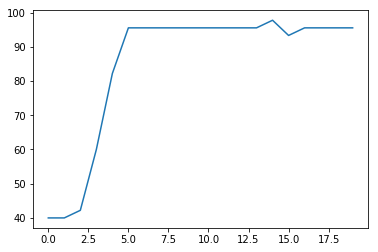

In [19]:
xs = np.zeros(nbepochs)
for x in range(len(results)):
    xs[x] = x
    
plt.plot(xs,results)
plt.show()

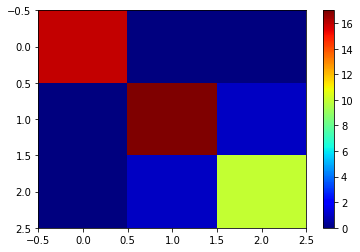

In [20]:
plt.imshow(conf_arr, cmap=plt.cm.jet, interpolation='nearest',aspect='auto')
plt.colorbar()
plt.show()

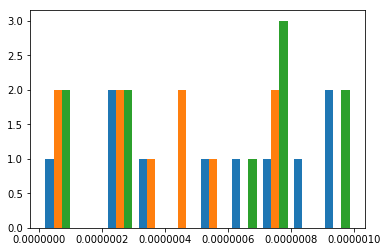

In [21]:
plt.hist(G)
plt.show()

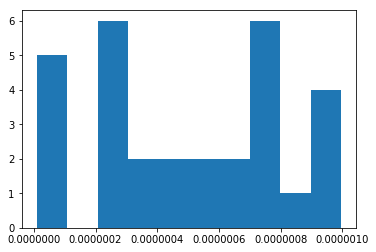

In [22]:
Gflat = np.ndarray.flatten(G)
plt.hist(Gflat)
plt.show()

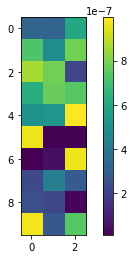

In [23]:
plt.imshow(G)
plt.colorbar()
plt.show()